**Baseline classifier model. Op basis van TF-IDF Logistische regressie. Moet class imbalance nog aanpakken.**

In [6]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import os

In [8]:
script_dir = os.getcwd() # Ga één map omhoog om 'baseline' te verwijderen en ga naar 'Data'
project_root = os.path.dirname(script_dir)  # Dit verwijdert 'baseline' van het script_dir
data_folder = os.path.join(project_root, "Data")

# 1. Dataset inladen
file_path = os.path.join(data_folder, "Kleine_data.xlsx")
df = pd.read_excel(file_path)

# 2. Data verkennen
print("Dataset overzicht:")
print(df.info())
print(df.head())

Dataset overzicht:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   context      1000 non-null   object
 1   question     1000 non-null   object
 2   statistical  1000 non-null   int64 
 3   theme        1000 non-null   object
 4   file_name    1000 non-null   object
dtypes: int64(1), object(4)
memory usage: 39.2+ KB
None
                                             context  \
0  Graag absolute aantallen en procentuele aantal...   
1  Graag een overzicht per waarborgdossier. Graag...   
2  Graag cijfers voor 2014, 2015, 2016, 2017, 201...   
3  Voor een aantal projecten die oorspronkelijk w...   
4  Een klanttevredenheidsonderzoek bevordert de e...   

                                            question  statistical  \
0         b) Welk budget werd daarvoor gereserveerd?            0   
1  Zijn er indicaties van financiële moeilijkhede...      

In [9]:
# 3. Missende waarden aanpakken
df = df.dropna(subset=["question"])  # Verwijder lege vragen
df["context"].fillna("", inplace=True)  # Vul missende context met lege string

# 4. Stopwoordenlijst (Nederlands, handmatig)
dutch_stopwords = {"de", "het", "een", "en", "van", "ik", "te", "dat", "die", "in", "je", "is", "niet", "op", "aan", "met", "als", "voor", "zijn", "was", "heeft", "heb", "om", "bij", "of", "geen", "dan", "toch", "maar", "wel", "meer", "doen", "ook", "kan", "mijn", "zo", "dus", "zou", "kunnen"}

def clean_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'\n', ' ', text)  # Nieuwe regels verwijderen
    text = re.sub(r'\b[a-z]\)\s+', ' ', text)  # Verwijder enumeraties zoals "a) b) c)" en voeg spatie toe
    text = re.sub(r'\b\d+\.\b', '', text)  # Verwijder numerieke opsommingen zoals "1. 2. 3."
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Speciale tekens verwijderen
    text = " ".join([word for word in text.split() if word not in dutch_stopwords])  # Stopwoorden verwijderen
    text = re.sub(r'\s+', ' ', text).strip()  # Dubbele spaties verwijderen
    return text

# 5. Data opschonen
df["clean_question"] = df["question"].apply(clean_text)

C:\Users\corne\AppData\Local\Temp\ipykernel_20716\254478967.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["context"].fillna("", inplace=True)  # Vul missende context met lege string


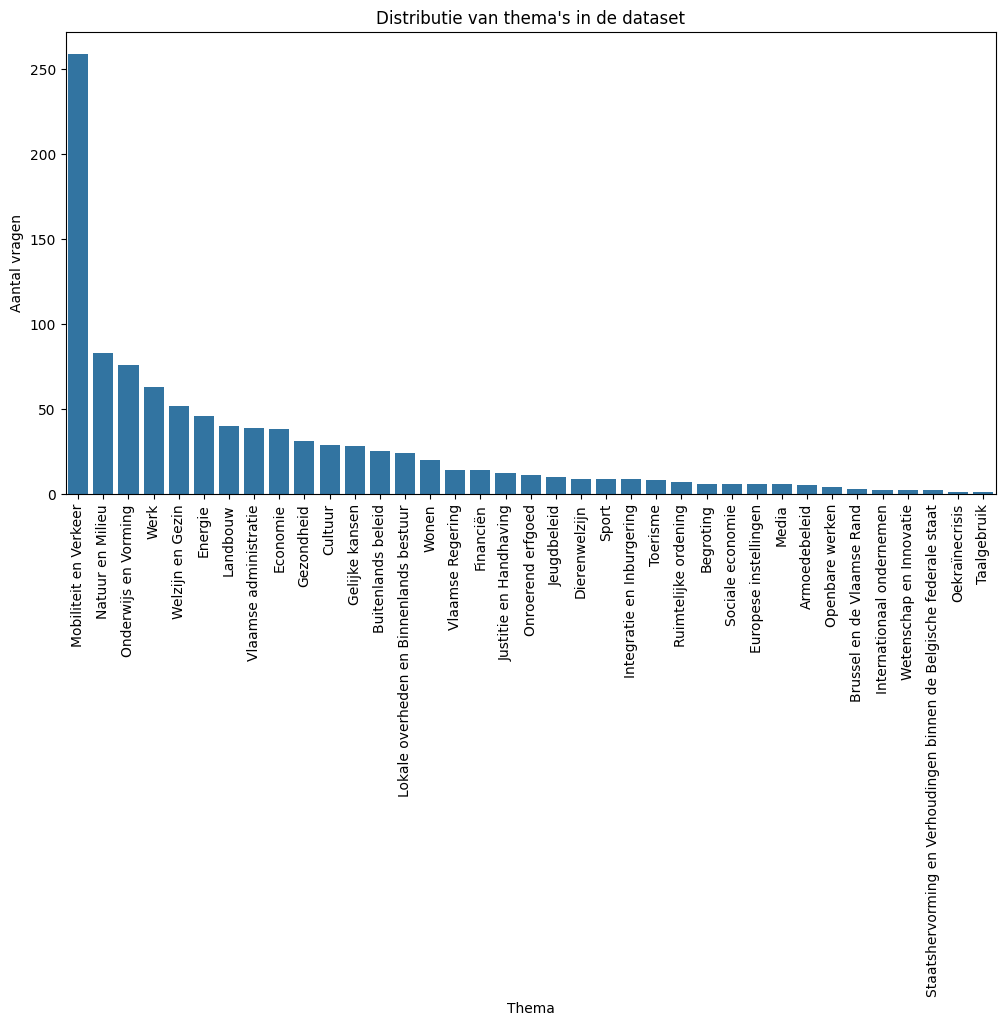

Top 10 thema's:
theme
Mobiliteit en Verkeer    259
Natuur en Milieu          83
Onderwijs en Vorming      76
Werk                      63
Welzijn en Gezin          52
Energie                   46
Landbouw                  40
Vlaamse administratie     39
Economie                  38
Gezondheid                31
Name: count, dtype: int64


In [10]:
# 6. Distributie van thema's plotten
theme_counts = df["theme"].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(x=theme_counts.index, y=theme_counts.values)
plt.xticks(rotation=90)
plt.title("Distributie van thema's in de dataset")
plt.xlabel("Thema")
plt.ylabel("Aantal vragen")
plt.show()

print("Top 10 thema's:")
print(theme_counts.head(10))

In [11]:
# 7. Baseline model - TF-IDF + Logistische Regressie
print("Training baseline model...")
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_question"])
y = df["theme"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistisch regressie model
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# Voorspellingen en evaluatie
y_pred = model.predict(X_test)
print("Model prestaties:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Training baseline model...
Model prestaties:
                                         precision    recall  f1-score   support

                          Armoedebeleid       0.00      0.00      0.00         1
                              Begroting       0.00      0.00      0.00         2
                     Buitenlands beleid       0.00      0.00      0.00         2
                                Cultuur       1.00      0.20      0.33         5
                               Economie       0.00      0.00      0.00         6
                                Energie       0.00      0.00      0.00         7
                  Europese instellingen       0.00      0.00      0.00         2
                              Financiën       0.00      0.00      0.00         3
                         Gelijke kansen       0.00      0.00      0.00         6
                             Gezondheid       0.00      0.00      0.00         4
              Integratie en Inburgering       0.00      0.00   

c:\Users\corne\anaconda3\envs\thesis-env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\corne\anaconda3\envs\thesis-env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\corne\anaconda3\envs\thesis-env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r